In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
data_dir = "../../../data/02__mpra/02__activs"
human_max_f = "%s/human_TSS_vals.max_tile.txt" % data_dir
mouse_max_f = "%s/mouse_TSS_vals.max_tile.txt" % data_dir

In [5]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_cis_trans_effects_data.txt" % results_dir

In [6]:
cov_dir = "../../../data/05__motif_coverage"
human_bp_cov_f = "%s/hg19_evo_fimo_sig.bp_covered.txt" % cov_dir
human_max_cov_f = "%s/hg19_evo_fimo_sig.max_coverage.txt" % cov_dir
mouse_bp_cov_f = "%s/mm9_evo_fimo_sig.bp_covered.txt" % cov_dir
mouse_max_cov_f = "%s/mm9_evo_fimo_sig.max_coverage.txt" % cov_dir

## 1. import data

In [7]:
human_max = pd.read_table(human_max_f, sep="\t")
mouse_max = pd.read_table(mouse_max_f, sep="\t")
human_max.head()

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype
0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,1.848145e-02,sig,mRNA
1,GGGCGGGACGGAGACTCTGGGCTCAAGGCTCCTGGAAATGGGCGGG...,h.998,div_pc,tile2,0.885958,-0.052587,1.044316e-06,sig,mRNA
2,AAAAGGCAGTGCTTGATTCAATTCAACATTCACTGCGCCACTTACC...,h.997,div_pc,tile2,0.423129,-0.373527,2.996315e-01,not sig,mRNA
3,CGGAGGGGCGGGGCAAGAGTGGGAGGAGACCCTGCGCGCGGCCGCC...,h.996,div_pc,tile2,2.452145,0.389546,5.019212e-74,sig,mRNA
4,AGGGTGGTGCGTGGTCTACGGCGAGCGGAGTGGGGCGGGGTCGCGC...,h.995,div_pc,tile1,0.994045,-0.002594,6.400385e-09,sig,mRNA


In [8]:
results = pd.read_table(results_f)
results.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_detail_human,fdr_trans_mouse,logFC_trans_mouse,abs_logFC_trans_mouse,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,no trans effect,0.585918,-0.384559,0.384559,no trans effect,no trans effect,no trans effect,no trans effect,-0.384559,0.384559
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,no trans effect,0.492102,0.500227,0.500227,no trans effect,no trans effect,no trans effect,no trans effect,1.300086,1.300086
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,no trans effect,0.902393,-0.088485,0.088485,no trans effect,no trans effect,no trans effect,no trans effect,0.443366,0.443366
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.311051,0.460589,0.460589,no trans effect,no trans effect,no trans effect,no trans effect,0.460589,0.460589
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.375934,0.447387,0.447387,no trans effect,no trans effect,no trans effect,no trans effect,0.447387,0.447387


In [9]:
human_bp_cov = pd.read_table(human_bp_cov_f, header=None)
human_bp_cov.columns = ["chr", "start", "end", "name", "tile", "strand", "n1", "n2", "n3", "perc_bp_cov"]

mouse_bp_cov = pd.read_table(mouse_bp_cov_f, header=None)
mouse_bp_cov.columns = ["chr", "start", "end", "name", "tile", "strand", "n1", "n2", "n3", "perc_bp_cov"]

human_bp_cov.head()

,chr,start,end,name,tile,strand,n1,n2,n3,perc_bp_cov
0,chr1,1355317,1355461,HUMAN_EVO_TSS__h.1539__tile2;WT,2,+,9,95,144,0.659722
1,chr1,1355431,1355575,HUMAN_EVO_TSS__h.1539__tile1;WT,1,+,17,135,144,0.937500
2,chr1,1447313,1447457,HUMAN_EVO_TSS__h.3020__tile2;WT,2,+,5,78,144,0.541667
3,chr1,1447388,1447532,HUMAN_EVO_TSS__h.2871__tile1;WT,1,-,7,114,144,0.791667
4,chr1,1447427,1447571,HUMAN_EVO_TSS__h.3020__tile1;WT,1,+,6,88,144,0.611111


In [10]:
human_max_cov = pd.read_table(human_max_cov_f, header=None)
human_max_cov.columns = ["name", "max_cov"]

mouse_max_cov = pd.read_table(mouse_max_cov_f, header=None)
mouse_max_cov.columns = ["name", "max_cov"]

human_max_cov.head()

,name,max_cov
0,HUMAN_EVO_TSS__h.0__tile1;WT,4
1,HUMAN_EVO_TSS__h.0__tile2;WT,5
2,HUMAN_EVO_TSS__h.1000__tile1;WT,1
3,HUMAN_EVO_TSS__h.1000__tile2;WT,5
4,HUMAN_EVO_TSS__h.1001__tile1;WT,6


## 2. join coverage w/ results

In [11]:
human_bp_cov["hg19_id"] = human_bp_cov["name"].str.split("__", expand=True)[1]
human_bp_cov["tss_tile_num"] = human_bp_cov["name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
human_max_cov["hg19_id"] = human_max_cov["name"].str.split("__", expand=True)[1]
human_max_cov["tss_tile_num"] = human_max_cov["name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
human_max_cov.sample(5)

,name,max_cov,hg19_id,tss_tile_num
1924,HUMAN_EVO_TSS__h.1891__tile1;WT,2,h.1891,tile1
3463,HUMAN_EVO_TSS__h.2602__tile2;WT,2,h.2602,tile2
6948,HUMAN_EVO_TSS__h.925__tile1;WT,1,h.925,tile1
2753,HUMAN_EVO_TSS__h.2273__tile1;WT,2,h.2273,tile1
4133,HUMAN_EVO_TSS__h.2911__tile1;WT,3,h.2911,tile1


In [12]:
mouse_bp_cov["mm9_id"] = mouse_bp_cov["name"].str.split("__", expand=True)[1]
mouse_bp_cov["tss_tile_num"] = mouse_bp_cov["name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
mouse_max_cov["mm9_id"] = mouse_max_cov["name"].str.split("__", expand=True)[1]
mouse_max_cov["tss_tile_num"] = mouse_max_cov["name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
mouse_max_cov.sample(5)

,name,max_cov,mm9_id,tss_tile_num
5279,MOUSE_EVO_TSS__m.3459__tile2;WT,2,m.3459,tile2
3108,MOUSE_EVO_TSS__m.245__tile1;WT,2,m.245,tile1
5643,MOUSE_EVO_TSS__m.467__tile1;WT,5,m.467,tile1
832,MOUSE_EVO_TSS__m.1392__tile2;WT,4,m.1392,tile2
3515,MOUSE_EVO_TSS__m.2648__tile2;WT,3,m.2648,tile2


In [13]:
len(human_max)

3345

In [14]:
human_max = human_max.merge(human_bp_cov[["hg19_id", "tss_tile_num", "perc_bp_cov"]],
                            left_on=["tss_id", "tss_tile_num"], right_on=["hg19_id", "tss_tile_num"])
len(human_max)

3344

In [15]:
human_max = human_max.merge(human_max_cov[["hg19_id", "tss_tile_num", "max_cov"]],
                            left_on=["hg19_id", "tss_tile_num"], right_on=["hg19_id", "tss_tile_num"])
len(human_max)

3262

In [16]:
# FOR LATER - WHY DO THESE 2 FILES HAVE DIFF # OF SEQS? SHOULD BE SAME
len(human_max_cov)

7115

In [17]:
len(human_bp_cov)

7316

In [18]:
len(mouse_max)

3261

In [19]:
mouse_max = mouse_max.merge(mouse_bp_cov[["mm9_id", "tss_tile_num", "perc_bp_cov"]],
                            left_on=["tss_id", "tss_tile_num"], right_on=["mm9_id", "tss_tile_num"])
len(mouse_max)

3260

In [20]:
mouse_max = mouse_max.merge(mouse_max_cov[["mm9_id", "tss_tile_num", "max_cov"]],
                            left_on=["mm9_id", "tss_tile_num"], right_on=["mm9_id", "tss_tile_num"])
len(mouse_max)

3163

In [21]:
results = results.merge(human_max[["hg19_id", "perc_bp_cov", "max_cov"]], on="hg19_id", how="left")
results = results.merge(mouse_max[["mm9_id", "perc_bp_cov", "max_cov"]], on="mm9_id", how="left",
                        suffixes=("_hg19", "_mm9"))
print(len(results))
results.sample(5)

3279


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max,perc_bp_cov_hg19,max_cov_hg19,perc_bp_cov_mm9,max_cov_mm9
2537,chr11,8615962,8615963,+,no cage activity,no cage activity,no cage activity,True,False,chr7,...,no trans effect,no trans effect,no trans effect,no trans effect,0.412168,0.412168,0.763889,4.0,0.652778,2.0
7,chr1,98515153,98515154,-,"chr1:98515146..98515159,-",intergenic,ENSG00000225206.4,True,True,chr3,...,no trans effect,no trans effect,no trans effect,no trans effect,-0.197617,0.197617,0.201389,1.0,0.451389,2.0
1211,chr2,157192212,157192213,-,chr2:157191997-157192231,enhancer,chr2:157191997-157192231__NEGATIVE,True,True,chr2,...,no trans effect,no trans effect,no trans effect,no trans effect,0.181105,0.181105,0.756944,2.0,0.409722,2.0
2499,chr4,24586343,24586344,+,no cage activity,no cage activity,no cage activity,True,False,chr5,...,no trans effect,no trans effect,no trans effect,no trans effect,0.786994,0.786994,0.645833,5.0,0.770833,3.0
466,chr3,45730784,45730785,+,"chr3:45730784..45730791,+",div_pc,ENSG00000211456.6,True,True,chr9,...,no trans effect,no trans effect,no trans effect,no trans effect,0.245629,0.245629,0.423611,2.0,0.347222,1.0


In [22]:
results["bp_cov_change"] = results["perc_bp_cov_mm9"] - results["perc_bp_cov_hg19"]
results["max_cov_change"] = results["max_cov_mm9"] - results["max_cov_hg19"]

In [23]:
results["abs_bp_cov_change"] = np.abs(results["bp_cov_change"])
results["abs_max_cov_change"] = np.abs(results["max_cov_change"])

## 3. plot

In [24]:
data_filt = results[(results["HUES64_padj_hg19"] < 0.05) | (results["mESC_padj_mm9"] < 0.05)]
data_filt = data_filt[~data_filt["cis_status_detail_one"].str.contains("interaction")]
len(data_filt)

1831

In [25]:
data_filt.fillna(0, inplace=True)

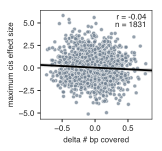

In [26]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="bp_cov_change", y="logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["bp_cov_change"])) & 
                   (~pd.isnull(data_filt["logFC_cis_max"]))]
r, p = spearmanr(no_nan["bp_cov_change"], no_nan["logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("delta # bp covered")
plt.ylabel("maximum cis effect size")
fig.savefig("cis_effect_v_delta_bp_cov.pdf", dpi="figure", bbox_inches="tight")

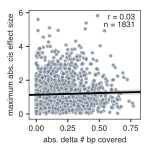

In [27]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="abs_bp_cov_change", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["abs_bp_cov_change"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["abs_bp_cov_change"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("abs. delta # bp covered")
plt.ylabel("maximum abs. cis effect size")
fig.savefig("cis_effect_v_delta_bp_cov.abs.pdf", dpi="figure", bbox_inches="tight")

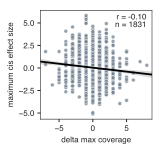

In [28]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="max_cov_change", y="logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["max_cov_change"])) & 
                   (~pd.isnull(data_filt["logFC_cis_max"]))]
r, p = spearmanr(no_nan["max_cov_change"], no_nan["logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("delta max coverage")
plt.ylabel("maximum cis effect size")
fig.savefig("cis_effect_v_delta_max_cov.pdf", dpi="figure", bbox_inches="tight")

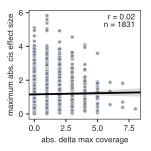

In [29]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="abs_max_cov_change", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["abs_max_cov_change"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["abs_max_cov_change"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("abs. delta max coverage")
plt.ylabel("maximum abs. cis effect size")
fig.savefig("cis_effect_v_delta_max_cov.abs.pdf", dpi="figure", bbox_inches="tight")